<a href="https://colab.research.google.com/github/Adi-204/AmazonML/blob/main/Copy_of_DeepFake_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%matplotlib inline

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image
import random
import torch.nn.functional as F

In [ ]:
import cv2
import os

# Path to the folder containing video files in your Google Drive
video_folder_path = '/content/drive/MyDrive/Celeb-DF-v2.zip (Unzipped Files)/Celeb-synthesis'

# Output folder for extracted frames
output_frames_path = '/content/drive/MyDrive/Single_Extracted/Celeb-synthesis'
os.makedirs(output_frames_path, exist_ok=True)

# Number of frames to extract from each video
num_frames_to_extract = 1

# Iterate through all video files in the folder
for video_file in os.listdir(video_folder_path):
    if video_file.endswith(('.mp4', '.avi', '.mov')):  # Add other video formats if needed
        video_path = os.path.join(video_folder_path, video_file)
        cap = cv2.VideoCapture(video_path)

        frame_count = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // num_frames_to_extract)

        success, frame = cap.read()
        while success and frame_count < num_frames_to_extract:
            # Save frame as an image file
            frame_filename = f"{os.path.splitext(video_file)[0]}_frame{frame_count}.jpg"
            cv2.imwrite(os.path.join(output_frames_path, frame_filename), frame)

            # Move to the next frame based on the step
            cap.set(cv2.CAP_PROP_POS_FRAMES, step * (frame_count + 1))
            frame_count += 1
            success, frame = cap.read()

        cap.release()
        print(f"Extracted {frame_count} frames from {video_file}")

print("Frame extraction completed.")

In [5]:

# Load YOLOv5 model (pretrained on COCO dataset, which includes face detection)
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

def detect_and_crop(image_path):
    img = Image.open(image_path)

    # YOLO model inference
    results = yolo_model(img)

    # Extract bounding boxes for eyes, nose, and face
    # Assuming YOLO is pretrained on detecting these objects
    detected_features = results.pandas().xyxy[0]
    crops = {}

    # Iterate through detected bounding boxes
    for _, row in detected_features.iterrows():
        # Adjust according to YOLO's class labels for eye, nose, and face
        if row['name'] == 'face':
            crops['face'] = img.crop((row['xmin'], row['ymin'], row['xmax'], row['ymax']))
        elif row['name'] == 'eye':  # Modify if different classes for left and right eyes
            crops['eye'] = img.crop((row['xmin'], row['ymin'], row['xmax'], row['ymax']))
        elif row['name'] == 'nose':
            crops['nose'] = img.crop((row['xmin'], row['ymin'], row['xmax'], row['ymax']))

    return crops  # Return cropped images (face, eye, and nose)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-27 Python-3.10.12 torch-2.5.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [22]:
!pip install --upgrade pip==20.3.4  # Downgrade to pip version 20.3.4 (you can use any version under 24.1)
!pip install yolov5facedetector

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
     |████████████████████████████████| 102 kB 2.6 MB/s 
     |████████████████████████████████| 16.0 MB 5.5 MB/s 
     |████████████████████████████████| 16.0 MB 56.3 MB/s 
     |████████████████████████████████| 314 kB 105.6 MB/s 


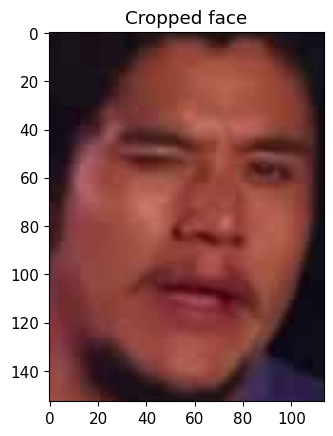

In [5]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
from yolov5facedetector.face_detector import YoloDetector
import numpy as np  # Import NumPy


# Load the YOLOv5 model using YoloDetector
yolo_model = YoloDetector(target_size=720, gpu=0, min_face=90)

def detect_and_crop(image_path):
    img = Image.open(image_path)

    # Convert the PIL Image to a NumPy array
    img_np = np.array(img)

    # Perform YOLO inference using predict method
    bboxes, confs, points = yolo_model.predict(img_np)

    # Extract bounding boxes for eyes, nose, and face
    # (Note: This part might need adjustments based on the output format of predict)
    crops = {}

    # Iterate through detected objects (replace with actual logic)
    for bbox in bboxes:
        # Assuming bbox is a list of lists, where each inner list represents a bounding box
        # Iterate through the coordinates in each bounding box
        bbox_coords = [int(coord) for coord in bbox[0]]  # Access the first element (list of coordinates)

        # Crop face region
        face_region = img.crop(bbox_coords)
        crops['face'] = face_region

        # Approximate eye and nose regions within the face region
        face_width = bbox_coords[2] - bbox_coords[0]
        face_height = bbox_coords[3] - bbox_coords[1]

        # Approximate eye regions (adjust factors as needed)
        eye_width = face_width * 0.2  # Assume eye width is 20% of face width
        eye_height = face_height * 0.15  # Assume eye height is 15% of face height
        eye_x_offset = face_width * 0.25  # Assume eyes are 25% from the left and right edges
        eye_y_offset = face_height * 0.3  # Assume eyes are 30% from the top edge

        left_eye_coords = [bbox_coords[0] + eye_x_offset,
                           bbox_coords[1] + eye_y_offset,
                           bbox_coords[0] + eye_x_offset + eye_width,
                           bbox_coords[1] + eye_y_offset + eye_height]
        right_eye_coords = [bbox_coords[2] - eye_x_offset - eye_width,
                            bbox_coords[1] + eye_y_offset,
                            bbox_coords[2] - eye_x_offset,
                            bbox_coords[1] + eye_y_offset + eye_height]

        crops['left_eye'] = img.crop(left_eye_coords)
        crops['right_eye'] = img.crop(right_eye_coords)

        # Approximate nose region (adjust factors as needed)
        nose_width = face_width * 0.15  # Assume nose width is 15% of face width
        nose_height = face_height * 0.2  # Assume nose height is 20% of face height
        nose_x_offset = face_width * 0.5 - nose_width / 2  # Center the nose horizontally
        nose_y_offset = face_height * 0.45  # Assume nose is 45% from the top edge

        nose_coords = [bbox_coords[0] + nose_x_offset,
                       bbox_coords[1] + nose_y_offset,
                       bbox_coords[0] + nose_x_offset + nose_width,
                       bbox_coords[1] + nose_y_offset + nose_height]

        crops['nose'] = img.crop(nose_coords)

    return crops

# Path to your image
image_path = '/content/drive/MyDrive/Colab Notebooks/Single_Extracted/Celeb-real/00004_frame0.jpg'

# Detect and crop
crops = detect_and_crop(image_path)

# Display the cropped regions (if found)
if crops:
    for feature, crop_img in crops.items():
        plt.imshow(crop_img)
        plt.title(f"Cropped {feature}")
        plt.show()
else:
    print("No face, eye, or nose detected in the image.")

In [6]:
class DeepFakeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for filename in os.listdir(data_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                self.image_paths.append(os.path.join(data_dir, filename))
                label = 1 if "real" in filename else 0  # Assuming file name contains "real" or "fake"
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)

        # Detect and crop face, eye, nose using YOLO
        crops = detect_and_crop(img_path)

        if self.transform:
            face_img = self.transform(crops.get('face'))
            eye_img = self.transform(crops.get('eye'))
            nose_img = self.transform(crops.get('nose'))
        else:
            face_img = crops.get('face')
            eye_img = crops.get('eye')
            nose_img = crops.get('nose')

        label = self.labels[idx]
        return eye_img, nose_img, face_img, label

In [7]:
def oversample_dataset(real_dataset, fake_dataset):
    real_count = len(real_dataset)
    fake_count = len(fake_dataset)
    oversampled_real_frames = []

    while len(oversampled_real_frames) < fake_count:
        oversampled_real_frames.extend(real_dataset.image_paths)

    random.shuffle(oversampled_real_frames)
    oversampled_real_frames = oversampled_real_frames[:fake_count]

    combined_frames = oversampled_real_frames + fake_dataset.image_paths
    combined_labels = [1] * len(oversampled_real_frames) + [0] * len(fake_dataset.image_paths)

    return combined_frames, combined_labels

# Data transforms (e.g., resizing and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets for real and fake frames
real_dataset = DeepFakeDataset(data_dir="/content/drive/MyDrive/Colab Notebooks/Single_Extracted/Celeb-real", transform=transform)
fake_dataset = DeepFakeDataset(data_dir="/content/drive/MyDrive/Colab Notebooks/Single_Extracted/Celeb-synthesis", transform=transform)


# Perform oversampling on the real dataset to match the size of the fake dataset
combined_frames, combined_labels = oversample_dataset(real_dataset, fake_dataset)

In [8]:
class CombinedDataset(Dataset):
    def __init__(self, frames, labels, transform=None):
        self.frames = frames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        img_path = self.frames[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        crops = detect_and_crop(img_path)

        if crops.get('face') is None or crops.get('eye') is None or crops.get('nose') is None:
            # Instead of returning the original image, we'll return tensors with the same shape as the transformed crops
            # This will keep the DataLoader happy
            image = self.transform(image)
            face_img = torch.zeros_like(image) # Replace with placeholder or error handling as needed
            eye_img = torch.zeros_like(image)
            nose_img = torch.zeros_like(image)
            return eye_img, nose_img, face_img, label

        if self.transform:
            image = self.transform(image)
            face_img = self.transform(crops.get('face'))
            eye_img = self.transform(crops.get('eye'))
            nose_img = self.transform(crops.get('nose'))


        label = self.labels[idx]
        return eye_img, nose_img, face_img, label

# Create a new combined dataset with oversampling applied
combined_dataset = CombinedDataset(combined_frames, combined_labels, transform=transform)

# Dataset splitting: 70% training, 15% validation, 15% testing
total_length = len(combined_dataset)
train_len = int(0.7 * total_length)
val_len = int(0.15 * total_length)
test_len = total_length - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_len, val_len, test_len])

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

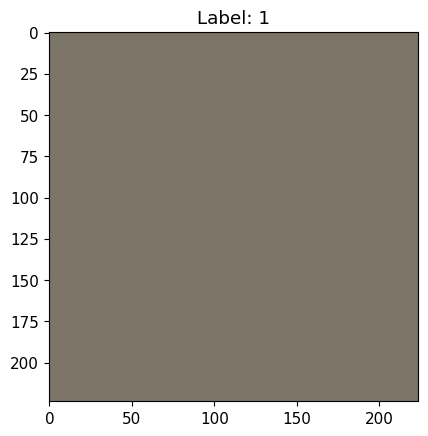

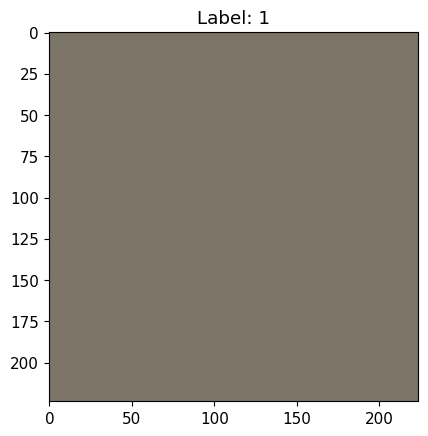

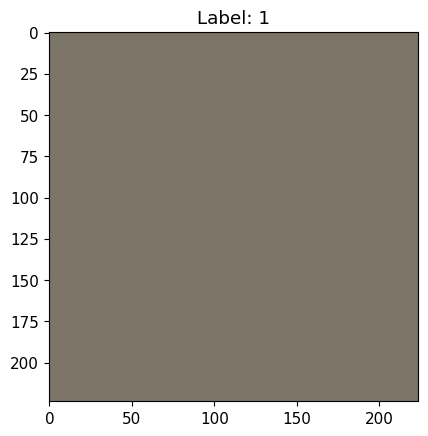

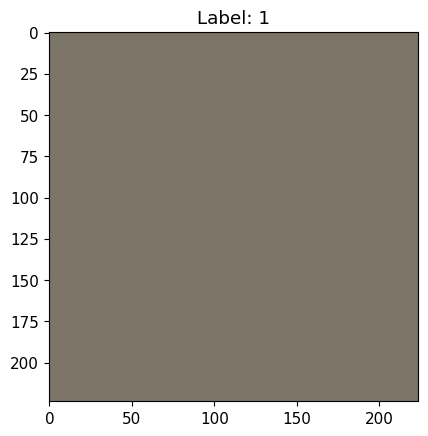

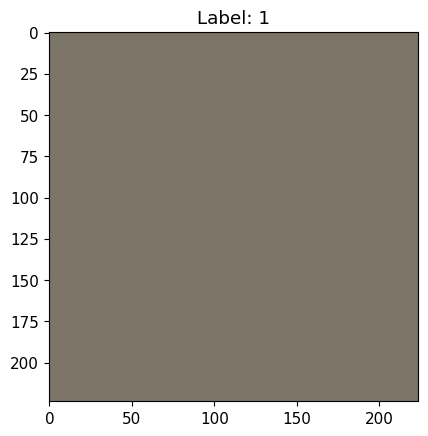

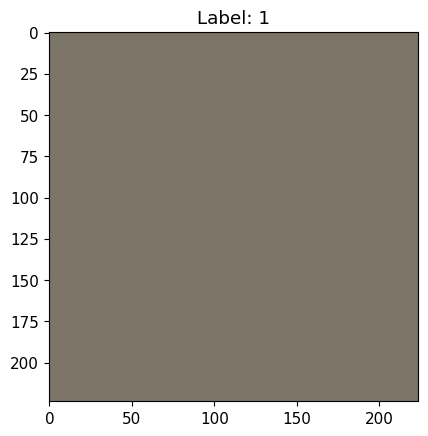

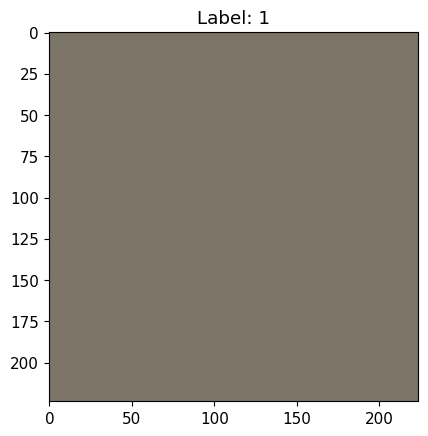

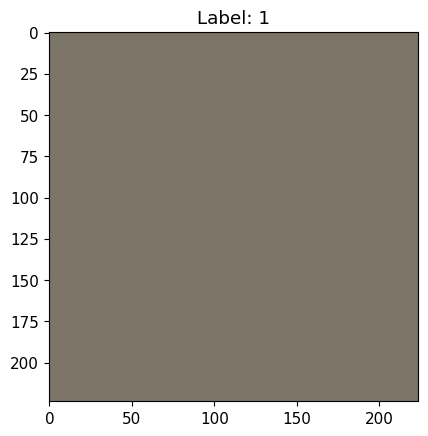

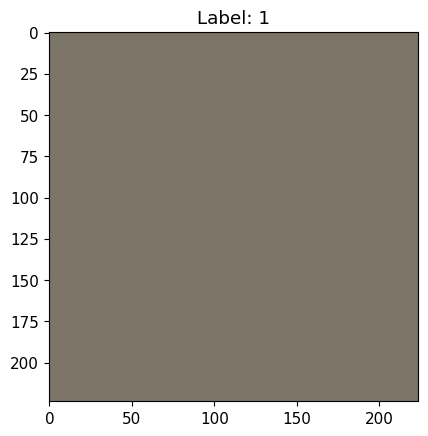

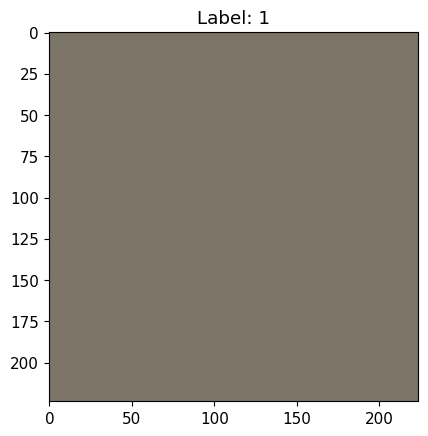

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# Assuming your combined_dataset is already defined
num_images_to_display = 10

for i in range(num_images_to_display):
    eye_img, nose_img, face_img, label = combined_dataset[i]  # Get the ith data point

    # Display the image
    img_np = face_img.cpu().numpy().transpose(1, 2, 0)  # Convert face_img to NumPy array and transpose
    img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Denormalize
    img_np = np.clip(img_np, 0, 1)  # Clip values

    plt.imshow(img_np)
    plt.title(f"Label: {label}")  # Show the label as the title
    plt.show()

In [9]:
resnet = models.resnet50(pretrained=True)

# Backbone model with branches for eye, nose, and face detection
class BackboneWithBranches(nn.Module):
    def __init__(self):
        super(BackboneWithBranches, self).__init__()
        # ResNet backbone (excluding final FC layer)
        self.shared_backbone = nn.Sequential(*(list(resnet.children())[:-2]))

        # Eye Detection Branch
        self.eye_conv = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.eye_fc = nn.Sequential(
                nn.Linear(512 * 3 * 3, 256),
                nn.ReLU(),
                nn.Dropout(0.5)
        )
        self.eye_classifier = nn.Linear(256, 2)

        # Nose Detection Branch
        self.nose_conv = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.nose_fc = nn.Sequential(
                nn.Linear(512 * 3 * 3, 256),
                nn.ReLU(),
                nn.Dropout(0.5)
        )
        self.nose_classifier = nn.Linear(256, 2)

        # Face Detection Branch
        self.face_conv = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.face_fc = nn.Sequential(
                nn.Linear(512 * 3 * 3, 256),
                nn.ReLU(),
                nn.Dropout(0.5)
        )
        self.face_classifier = nn.Linear(256, 2)

    def forward(self, eye_img, nose_img, face_img):
        # Feature extraction for eye
        eye_features = self.shared_backbone(eye_img)
        eye_features = self.eye_conv(eye_features)
        eye_features = eye_features.view(eye_features.size(0), -1)  # Flatten
        eye_output = self.eye_classifier(self.eye_fc(eye_features))

        # Feature extraction for nose
        nose_features = self.shared_backbone(nose_img)
        nose_features = self.nose_conv(nose_features)
        nose_features = nose_features.view(nose_features.size(0), -1)
        nose_output = self.nose_classifier(self.nose_fc(nose_features))

        # Feature extraction for face
        face_features = self.shared_backbone(face_img)
        face_features = self.face_conv(face_features)
        face_features = face_features.view(face_features.size(0), -1)
        face_output = self.face_classifier(self.face_fc(face_features))

        return eye_output, nose_output, face_output


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [10]:
def majority_voting(eye_output, nose_output, face_output):
    outputs = torch.stack([eye_output, nose_output, face_output], dim=0)
    final_output = outputs.mean(dim=0)
    return final_output

In [4]:
pip install --upgrade torch ultralytics


In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def train(model, train_loader, criterion, optimizer, num_epochs=10, val_loader=None, save_path="model_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (eye_img, nose_img, face_img, labels) in enumerate(train_loader):
            eye_img, nose_img, face_img, labels = eye_img.to(device), nose_img.to(device), face_img.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            eye_output, nose_output, face_output = model(eye_img, nose_img, face_img)
            final_output = majority_voting(eye_output, nose_output, face_output)
            loss = criterion(final_output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(final_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        running_loss /= len(train_loader)



        # Validation loop (if validation data is provided)
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_batch in val_loader:
                    eye_img_val, nose_img_val, face_img_val, labels_val = val_batch
                    eye_img_val, nose_img_val, face_img_val, labels_val = (
                        eye_img_val.to(device), nose_img_val.to(device), face_img_val.to(device), labels_val.to(device)
                    )

                    eye_output, nose_output, face_output = model(eye_img_val, nose_img_val, face_img_val)
                    final_output_val = majority_voting(eye_output, nose_output, face_output)
                    loss_val = criterion(final_output_val, labels_val)
                    val_loss += loss_val.item()
            val_loss /= len(val_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save model checkpoint after each epoch
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
        }
        torch.save(checkpoint, save_path)
        print(f"Model saved at epoch {epoch+1} to {save_path}")

# Model, criterion, and optimizer setup
model = BackboneWithBranches()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
num_epochs = 5

# Start training with train_loader and val_loader
train(model, train_loader, criterion, optimizer, num_epochs, val_loader=val_loader, save_path="/content/drive/MyDrive/Colab Notebooks/deepfake_detector_check.pth")

Epoch 1/5, Train Loss: 62.2130, Val Loss: 0.6995
Model saved at epoch 1 to /content/drive/MyDrive/Colab Notebooks/deepfake_detector_check.pth
Epoch 2/5, Train Loss: 59.9604, Val Loss: 0.6932
Model saved at epoch 2 to /content/drive/MyDrive/Colab Notebooks/deepfake_detector_check.pth
Epoch 3/5, Train Loss: 59.6752, Val Loss: 0.6931
Model saved at epoch 3 to /content/drive/MyDrive/Colab Notebooks/deepfake_detector_check.pth


KeyboardInterrupt: 

In [ ]:
def load_model_checkpoint(model, optimizer, checkpoint_path):

    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    val_loss = checkpoint['loss']

    print(f"Checkpoint loaded. Resuming from epoch {epoch} with validation loss {val_loss:.4f}")
    print(f"Model state dict keys: {model.state_dict().keys()}")

    return model, optimizer, epoch, val_loss

checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/deepfake_detector_check.pth"
model, optimizer, start_epoch, best_val_loss = load_model_checkpoint(model, optimizer, checkpoint_path)

Checkpoint loaded. Resuming from epoch 2 with validation loss 59.6083
Model state dict keys: odict_keys(['shared_backbone.0.weight', 'shared_backbone.1.weight', 'shared_backbone.1.bias', 'shared_backbone.1.running_mean', 'shared_backbone.1.running_var', 'shared_backbone.1.num_batches_tracked', 'shared_backbone.4.0.conv1.weight', 'shared_backbone.4.0.bn1.weight', 'shared_backbone.4.0.bn1.bias', 'shared_backbone.4.0.bn1.running_mean', 'shared_backbone.4.0.bn1.running_var', 'shared_backbone.4.0.bn1.num_batches_tracked', 'shared_backbone.4.0.conv2.weight', 'shared_backbone.4.0.bn2.weight', 'shared_backbone.4.0.bn2.bias', 'shared_backbone.4.0.bn2.running_mean', 'shared_backbone.4.0.bn2.running_var', 'shared_backbone.4.0.bn2.num_batches_tracked', 'shared_backbone.4.0.conv3.weight', 'shared_backbone.4.0.bn3.weight', 'shared_backbone.4.0.bn3.bias', 'shared_backbone.4.0.bn3.running_mean', 'shared_backbone.4.0.bn3.running_var', 'shared_backbone.4.0.bn3.num_batches_tracked', 'shared_backbone.4.0.

In [ ]:
import torch
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_with_timing(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_time = 0.0
    total_images = 0

    with torch.no_grad():
        for batch in data_loader:
            eye_img, nose_img, face_img, labels = batch
            batch_size = labels.size(0)
            total_images += batch_size

            if torch.cuda.is_available():
                eye_img, nose_img, face_img, labels = (
                    eye_img.cuda(), nose_img.cuda(), face_img.cuda(), labels.cuda()
                )

            # Measure the time taken for each batch prediction
            start_time = time.time()
            eye_output, nose_output, face_output = model(eye_img, nose_img, face_img)
            final_output = majority_voting(eye_output, nose_output, face_output)
            end_time = time.time()

            # Update total time
            total_time += (end_time - start_time)

            _, preds = torch.max(final_output, 1)
            probs = torch.softmax(final_output, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate average time per batch and per image
    avg_time_per_batch = total_time / len(data_loader)
    avg_time_per_image = total_time / total_images

    return np.array(all_preds), np.array(all_labels), np.array(all_probs), total_time, avg_time_per_batch, avg_time_per_image

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Get predictions, ground truth, and timing information
preds, labels, probs, total_time, avg_time_per_batch, avg_time_per_image = evaluate_model_with_timing(model, test_loader)

# Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Print timing information
print(f"Total time taken for predictions: {total_time:.4f} seconds")
print(f"Average time per batch: {avg_time_per_batch:.4f} seconds")
print(f"Average time per image: {avg_time_per_image:.6f} seconds")

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# ROC and Precision-Recall curves (for binary classification)
if len(np.unique(labels)) == 2:  # Check if it's binary classification
    y_scores = probs[:, 1]  # Get probabilities for class 1
    plot_roc_curve(labels, y_scores)
    plot_precision_recall_curve(labels, y_scores)
else:
    print("ROC and Precision-Recall curves are only plotted for binary classification.")


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.am

Accuracy: 0.4671
Precision: 0.2182
Recall: 0.4671
F1-Score: 0.2974
Total time taken for predictions: 30.4415 seconds
Average time per batch: 1.6022 seconds
Average time per image: 0.026041 seconds
